In [1]:
# 0) 라이브러리 로드
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
)
from IPython.display import display

In [10]:

# 1) 가상 커머스 데이터 생성
np.random.seed(42)
n = 1000
df = pd.DataFrame({
    # 고객이 지난 달 사이트에 방문한 횟수
    'visits_last_30d': np.random.poisson(5, n),
    # 지난 달 사이트 체류 시간 (분)
    'time_on_site': np.random.normal(300, 50, n).clip(50, 600),
    # 지난 달 구매 횟수
    'purchases_last_30d': np.random.poisson(1, n),
    # 마지막 구매 이후 경과 일수
    'days_since_last_purchase': np.random.exponential(10, n).clip(0, 60)
})

# 로지스틱 함수를 이용해 재구매 확률 생성
logit = (
    0.4*df['visits_last_30d'] +
    0.005*df['time_on_site'] -
    0.6*df['days_since_last_purchase'] +
    0.8*df['purchases_last_30d']
)
prob = 1 / (1 + np.exp(-0.02*(logit - logit.mean())))
print(prob.value_counts())
df['reorder_30d'] = (np.random.rand(n) < prob).astype(int)

print(df['reorder_30d'].value_counts())


0.512419    1
0.427283    1
0.485098    1
0.471303    1
0.476158    1
           ..
0.502266    1
0.508085    1
0.524655    1
0.509494    1
0.488097    1
Name: count, Length: 1000, dtype: int64
reorder_30d
0    524
1    476
Name: count, dtype: int64


In [3]:

# 2) EDA: 구조·기초 통계·타깃 분포
print("■ DataFrame info")
display(df.info())

print("\n■ First 5 rows")
display(df.head())

print("\n■ Summary statistics")
display(df.describe().T)

print("\n■ 'reorder_30d' distribution")
display(df['reorder_30d'].value_counts(normalize=True).rename('ratio'))


■ DataFrame info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   visits_last_30d           1000 non-null   int64  
 1   time_on_site              1000 non-null   float64
 2   purchases_last_30d        1000 non-null   int64  
 3   days_since_last_purchase  1000 non-null   float64
 4   reorder_30d               1000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 39.2 KB


None


■ First 5 rows


,visits_last_30d,time_on_site,purchases_last_30d,days_since_last_purchase,reorder_30d
0,5,301.881316,1,5.609315,0
1,4,286.324951,1,5.240543,1
2,4,309.933793,2,1.209766,1
3,5,325.876005,2,11.274495,1
4,5,198.349963,1,12.109880,0



■ Summary statistics


,count,mean,std,min,25%,50%,75%,max
visits_last_30d,1000.0,4.985000,2.236465,0.000000,3.000000,5.000000,6.000000,12.000000
time_on_site,1000.0,297.156019,49.866796,120.896870,265.548461,298.342125,330.602724,450.735585
purchases_last_30d,1000.0,0.947000,0.906097,0.000000,0.000000,1.000000,1.000000,5.000000
days_since_last_purchase,1000.0,9.629676,9.346459,0.000528,2.864901,6.855714,13.352956,60.000000
reorder_30d,1000.0,0.476000,0.499674,0.000000,0.000000,0.000000,1.000000,1.000000



■ 'reorder_30d' distribution


reorder_30d
0    0.524
1    0.476
Name: ratio, dtype: float64


■ Feature–Target Correlations


,corr_with_target
reorder_30d,1.000000
time_on_site,0.005921
days_since_last_purchase,-0.023321
purchases_last_30d,-0.041503
visits_last_30d,-0.067951


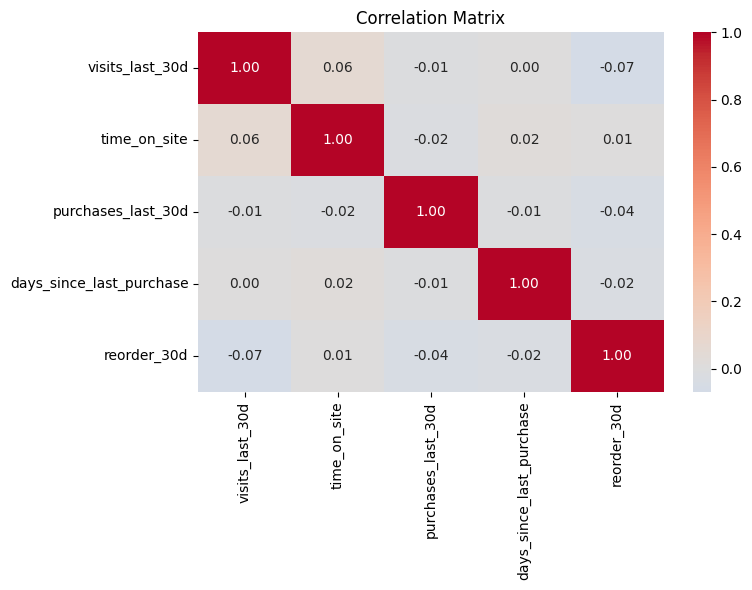

In [4]:


# 3) 상관관계 분석
corr = df.corr()
print("\n■ Feature–Target Correlations")
display(corr['reorder_30d'].sort_values(ascending=False).to_frame('corr_with_target'))

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [5]:

# 4) 학습/테스트 분할
X = df.drop('reorder_30d', axis=1)
y = df['reorder_30d']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# 5) 모델 학습
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
# 3) 모델 학습
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

# 4) 예측 및 평가
y_pred = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.52

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.72      0.61       157
           1       0.49      0.30      0.37       143

    accuracy                           0.52       300
   macro avg       0.51      0.51      0.49       300
weighted avg       0.51      0.52      0.50       300



In [ ]:

# 6) 예측 & 평가
# y_pred = clf.predict(X_test)
# print("\n■ Classification Report")
# print(classification_report(y_test, y_pred, digits=3))
# f1 = f1_score(y_test, y_pred)
# print(f"■ F1 Score          : {f1:.3f}")

models = { 'DecisionTree': clf, 'KNN': knn }
results = {}
for name, model in models.items() :
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred, digits=3, output_dict=True)

    results[name] = { 'f1': f1, 'report': cr, 'pred': y_pred}
    print(f"\n  {name} Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"\n f1 score: {f1}")




  DecisionTree Classification Report:
              precision    recall  f1-score   support

           0      0.506     0.554     0.529       157
           1      0.453     0.406     0.428       143

    accuracy                          0.483       300
   macro avg      0.479     0.480     0.478       300
weighted avg      0.481     0.483     0.481       300


 f1 score: 0.4280442804428044

  KNN Classification Report:
              precision    recall  f1-score   support

           0      0.531     0.720     0.611       157
           1      0.494     0.301     0.374       143

    accuracy                          0.520       300
   macro avg      0.512     0.510     0.492       300
weighted avg      0.513     0.520     0.498       300


 f1 score: 0.3739130434782609


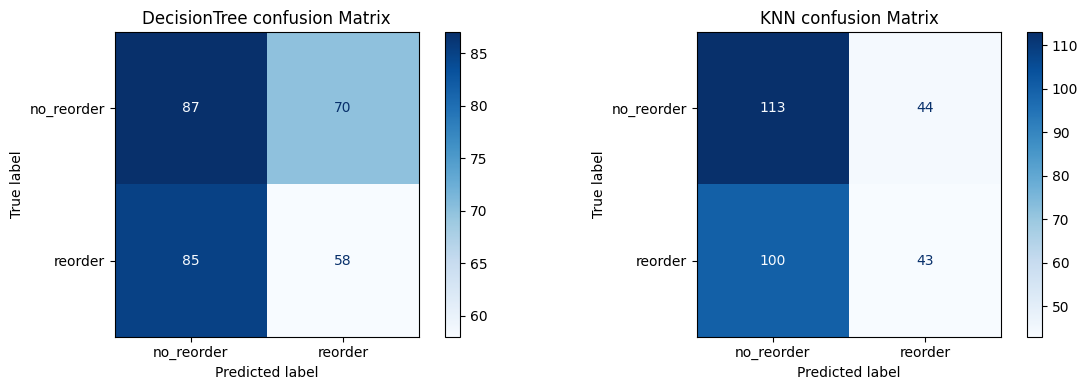

In [22]:

# 7) 혼동 행렬 시각화
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(cm, display_labels=['no_reorder','reorder'])
# disp.plot(cmap='Blues')
# plt.title("Confusion Matrix")
# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
for ax, (name, res) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, res['pred'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['no_reorder','reorder'])
    disp.plot(cmap='Blues', ax= ax)
    ax.set_title(f"{name} confusion Matrix")
plt.tight_layout()
plt.show()

    


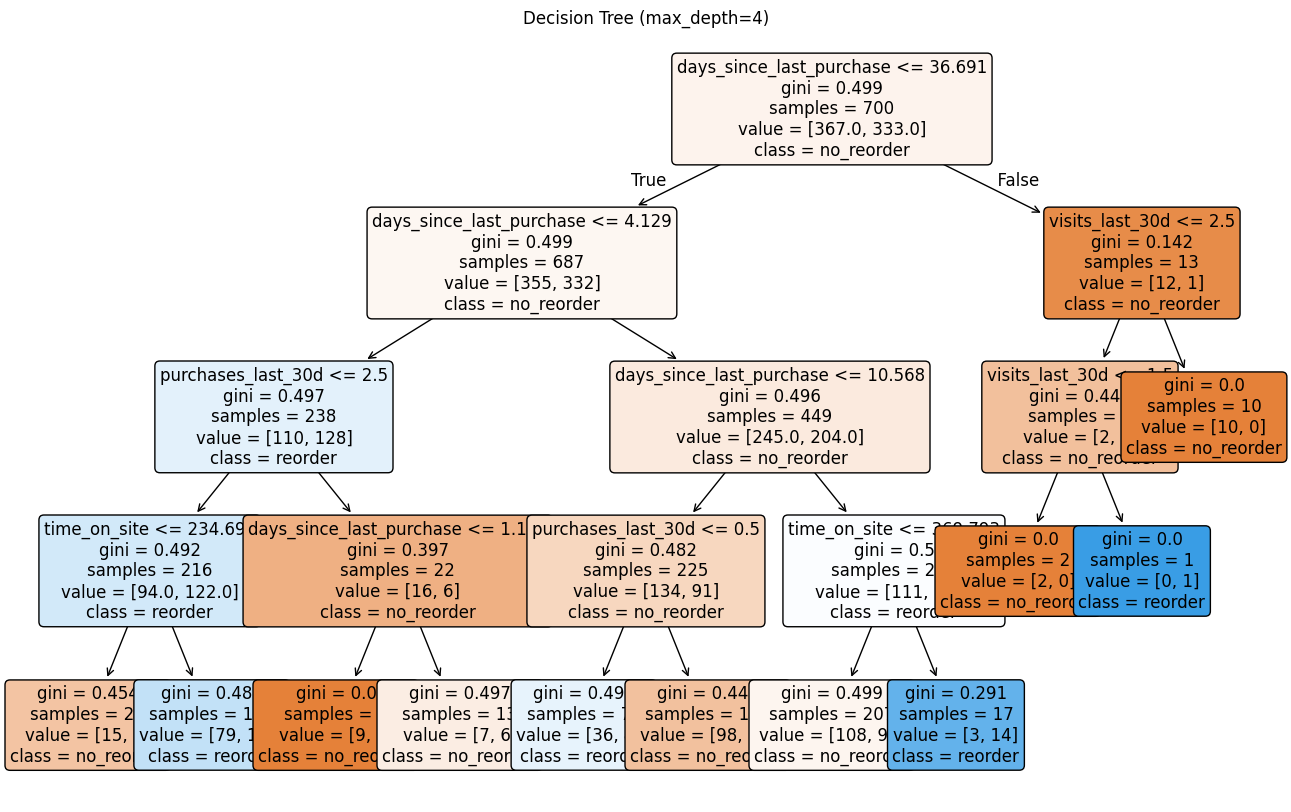

In [8]:
# 8) 결정트리 구조 시각화
plt.figure(figsize=(16,10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=['no_reorder','reorder'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree (max_depth=4)")
plt.show()


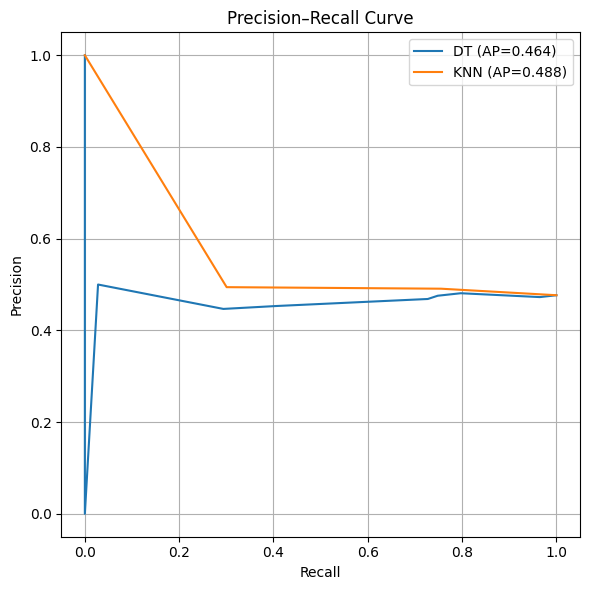

In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Decision Tree 확률 예측
y_prob_dt = clf.predict_proba(X_test)[:, 1]
(precision_dt, recall_dt, threshold_dt) = precision_recall_curve(y_test, y_prob_dt)
ap_dt = average_precision_score(y_test, y_prob_dt)
# recall_dt = results['DecisionTree'].cr['recall']
# precision_dt = results['DecisionTree'].cr['precision']
# KNN 확률 예측
y_prob_knn = knn.predict_proba(X_test)[:, 1]
precision_knn, recall_knn, threshold_knn  = precision_recall_curve(y_test, y_prob_knn)
ap_knn = average_precision_score(y_test, y_prob_knn)
# recall_knn = results['KNN'].cr['recall']
# precision_knn = results['KNN'].cr['precision']

# 그래프 그리기
plt.figure(figsize=(6,6))
plt.plot(recall_dt, precision_dt, label=f'DT (AP={ap_dt:.3f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AP={ap_knn:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()